# Training a model from fitness data

This code was adapted from the tutorial 'Get started with machine learning on Arduino' by Sandeep Mistry & Dominic Pajak in the Arduino blog. Special thanks for the Arduino team for giving the resources as a starting point-
[Link to the blog](https://blog.arduino.cc/2019/10/15/get-started-with-machine-learning-on-arduino/)

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("tensorflow:", tf.__version__)
print("seaborn", sns.__version__)

numpy: 1.19.5
pandas: 1.1.5
tensorflow: 2.5.0
seaborn 0.11.1


In [3]:
# Define constants required for program
np.set_printoptions(precision=3, suppress=True)

SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

ACTIONS = ["walking", "sitting", "standing"]
SAMPLES_PER_ACTION = 50
NUM_ACTIONS = len(ACTIONS)
ONE_HOT_ENCODED_ACTIONS = np.eye(NUM_ACTIONS)

In [4]:
# Parse the data
inputs = []
outputs = []

for i in range(NUM_ACTIONS):
  action = ACTIONS[i]
  print(f"Processing file for action '{action}'.")

  output = ONE_HOT_ENCODED_ACTIONS[i]
  df = pd.read_csv(action+".csv", skip_blank_lines=True)
  num_recordings = int(df.shape[0] / SAMPLES_PER_ACTION)
  print(f"\tThere are {num_recordings} recordings in the {action} file.")

  for i in range(num_recordings):
    tensor = []
    for j in range(SAMPLES_PER_ACTION):
      index = i * SAMPLES_PER_ACTION + j
      tensor += [
          (df['acc.x'][index]) / 4,
          (df['acc.y'][index]) / 4,
          (df['acc.z'][index]) / 4,
          (df['gyro.x'][index]) / 2000,
          (df['gyro.y'][index]) / 2000,
          (df['gyro.z'][index]) / 2000
      ]

    inputs.append(tensor)
    outputs.append(output)

inputs = np.array(inputs)
outputs = np.array(outputs)

print("Data set parsing and preparation complete.")

Processing file for action 'walking'.
	There are 30 recordings in the walking file.
Processing file for action 'sitting'.
	There are 30 recordings in the sitting file.
Processing file for action 'standing'.
	There are 30 recordings in the standing file.
Data set parsing and preparation complete.


In [5]:
# Randomize the order of the data and split into train, test and validation sets
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

inputs = inputs[randomize]
outputs = outputs[randomize]

TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

print("Data set randomization and splitting complete.")

Data set randomization and splitting complete.


In [6]:
# Build model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(50, activation='relu'))
model.add(tf.keras.layers.Dense(15, activation='relu'))
model.add(tf.keras.layers.Dense(NUM_ACTIONS, activation='softmax'))
model.compile(optimizer='rmsprop', loss='mse', metrics=['accuracy'])


In [7]:
# Train model
history = model.fit(inputs_train, outputs_train, epochs=100, batch_size=1, validation_data=(inputs_validate, outputs_validate))

Epoch 1/100
54/54 [==============================] - 1s 5ms/step - loss: 0.2094 - accuracy: 0.6481 - val_loss: 0.2045 - val_accuracy: 0.7778
Epoch 2/100
54/54 [==============================] - 0s 2ms/step - loss: 0.1746 - accuracy: 0.7963 - val_loss: 0.1710 - val_accuracy: 1.0000
Epoch 3/100
54/54 [==============================] - 0s 2ms/step - loss: 0.1353 - accuracy: 0.9444 - val_loss: 0.1422 - val_accuracy: 1.0000
Epoch 4/100
54/54 [==============================] - 0s 2ms/step - loss: 0.1034 - accuracy: 0.9630 - val_loss: 0.1086 - val_accuracy: 1.0000
Epoch 5/100
54/54 [==============================] - 0s 2ms/step - loss: 0.0784 - accuracy: 0.9815 - val_loss: 0.0811 - val_accuracy: 1.0000
Epoch 6/100
54/54 [==============================] - 0s 2ms/step - loss: 0.0604 - accuracy: 0.9630 - val_loss: 0.0581 - val_accuracy: 1.0000
Epoch 7/100
54/54 [==============================] - 0s 2ms/step - loss: 0.0465 - accuracy: 0.9815 - val_loss: 0.0376 - val_accuracy: 1.0000
Epoch 8/100
5

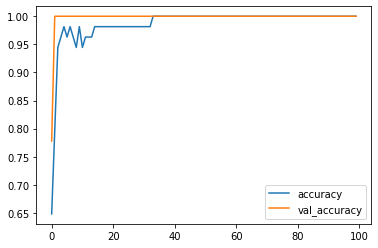

In [8]:
# Visualize the change in accuracy of model over the training process
metrics = history.history
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy','val_accuracy'])
plt.show()

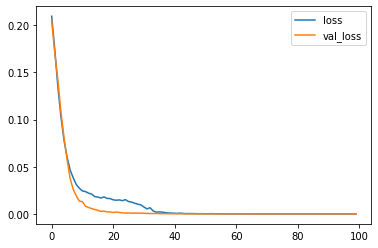

In [9]:
# Visualize the loss of the model over the training process
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss','val_loss'])
plt.show()

In [10]:
# Test model on the test data and measure accuracy
predictions = np.argmax(model.predict(inputs_test), axis=1)
true_values = np.argmax(outputs_test, axis=1)

test_acc = sum(predictions == true_values) / len(true_values)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 100%


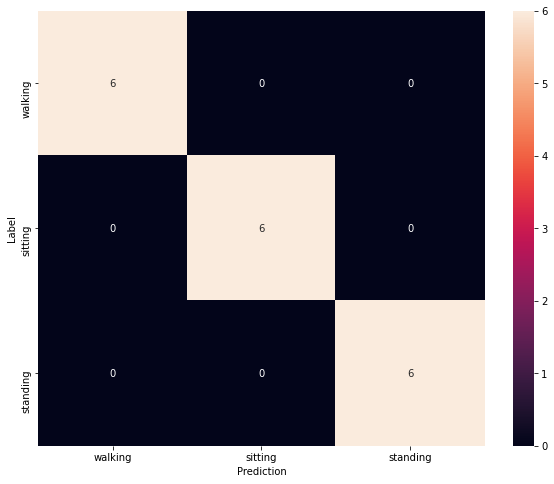

In [11]:
# Plot a confusion matrix for model on test data
confusion_mtx = tf.math.confusion_matrix(true_values, predictions) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=ACTIONS, yticklabels=ACTIONS, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [12]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("gesture_model.tflite", "wb").write(tflite_model)
  
import os
basic_model_size = os.path.getsize("gesture_model.tflite")
print("Model is %d bytes" % basic_model_size)

INFO:tensorflow:Assets written to: /tmp/tmpjrkiz_cs/assets
Model is 65128 bytes


In [13]:
!apt-get -qq install xxd

Selecting previously unselected package xxd.
(Reading database ... 160772 files and directories currently installed.)
Preparing to unpack .../xxd_2%3a8.0.1453-1ubuntu1.4_amd64.deb ...
Unpacking xxd (2:8.0.1453-1ubuntu1.4) ...
Setting up xxd (2:8.0.1453-1ubuntu1.4) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [14]:
!echo "const unsigned char model[] = {" > /content/model.h
!cat gesture_model.tflite | xxd -i      >> /content/model.h
!echo "};"                              >> /content/model.h

import os
model_h_size = os.path.getsize("model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

Header file, model.h, is 401,658 bytes.

Open the side panel (refresh if needed). Double click model.h to download the file.
